In [1]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import GRU, Dense, Flatten, Conv1D, LeakyReLU
from tensorflow.keras import Sequential, regularizers
from tensorflow.keras.losses import MeanSquaredError
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from pickle import load
import matplotlib.pyplot as plt
import pandas as pd

In [2]:

# Load preprocessed data and ensure consistent data types
X_train = tf.cast(np.load("X_train.npy", allow_pickle=True), tf.float32)  # Shape: (227, 5, 15)
y_train = tf.cast(np.load("y_train.npy", allow_pickle=True), tf.float32)  # Shape: (227, 1)
X_test = tf.cast(np.load("X_test.npy", allow_pickle=True), tf.float32)
y_test = tf.cast(np.load("y_test.npy", allow_pickle=True), tf.float32)
yc_train = tf.cast(np.load("yc_train.npy", allow_pickle=True), tf.float32)  # Shape: (227, 5, 1)
yc_test = tf.cast(np.load("yc_test.npy", allow_pickle=True), tf.float32)


In [3]:
# Define the Generator
def Generator(input_dim, output_dim, feature_size):
    model = Sequential()
    model.add(GRU(units=256, return_sequences=True, input_shape=(input_dim, feature_size), recurrent_dropout=0.02, recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(GRU(units=128, recurrent_dropout=0.02, recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(units=output_dim))
    return model

# Define the Discriminator
def Discriminator():
    model = Sequential()
    model.add(Conv1D(32, input_shape=(6, 1), kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(64, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Flatten())
    model.add(Dense(220, activation=LeakyReLU()))
    model.add(Dense(220, activation='relu'))
    model.add(Dense(1))
    return model

# GAN class with WGAN-GP
class GAN:
    def __init__(self, generator, discriminator):
        self.generator = generator
        self.discriminator = discriminator
        self.g_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.d_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.batch_size = 64
        self.checkpoint_dir = "./training_checkpoints"
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.g_optimizer, discriminator_optimizer=self.d_optimizer, generator=self.generator, discriminator=self.discriminator)

    def gradient_penalty(self, real, fake):
        alpha = tf.random.normal([real.shape[0], 1, 1], 0.0, 1.0, dtype=tf.float32)
        real = tf.cast(real, tf.float32)
        fake = tf.cast(fake, tf.float32)
        interpolated = real + alpha * (fake - real)
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))
        return tf.reduce_mean((norm - 1.0) ** 2)

    def train_step(self, X, y, yc):
        batch_size = tf.shape(X)[0]

        for _ in range(1):
            with tf.GradientTape() as d_tape:
                fake_y = self.generator(X, training=True)
                fake_concat = tf.concat([tf.expand_dims(fake_y, axis=-1), yc], axis=1)
                real_concat = tf.concat([tf.expand_dims(y, axis=-1), yc], axis=1)
                fake_logits = self.discriminator(fake_concat, training=True)
                real_logits = self.discriminator(real_concat, training=True)
                gp = self.gradient_penalty(real_concat, fake_concat)
                d_loss = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits) + 10.0 * gp

            d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))

        for _ in range(3):
            with tf.GradientTape() as g_tape:
                fake_y = self.generator(X, training=True)
                fake_concat = tf.concat([tf.expand_dims(fake_y, axis=-1), yc], axis=1)
                fake_logits = self.discriminator(fake_concat, training=True)
                g_loss = -tf.reduce_mean(fake_logits)

            g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return d_loss, g_loss

    def train(self, X_train, y_train, yc_train, epochs):
        d_losses, g_losses = [], []
        for epoch in range(epochs):
            d_loss, g_loss = self.train_step(X_train, y_train, yc_train)
            d_losses.append(d_loss.numpy())
            g_losses.append(g_loss.numpy())
            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch + 1}/{epochs}, D Loss: {d_loss.numpy()}, G Loss: {g_loss.numpy()}")
        return d_losses, g_losses

# Evaluation Function
def evaluate_model(y_true, y_pred, scaler):
    rescaled_true = scaler.inverse_transform(y_true)
    rescaled_pred = scaler.inverse_transform(y_pred)
    mse = mean_squared_error(rescaled_true, rescaled_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(rescaled_true, rescaled_pred)
    print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.4f}")
    return {"MSE": mse, "RMSE": rmse, "MAPE": mape}

In [4]:
# Training and Plotting
input_dim = 5  # Time steps
feature_size = 15  # Features per time step
output_dim = 1  # Single target value



In [5]:
generator = Generator(input_dim, output_dim, feature_size)
discriminator = Discriminator()
gan = GAN(generator, discriminator)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


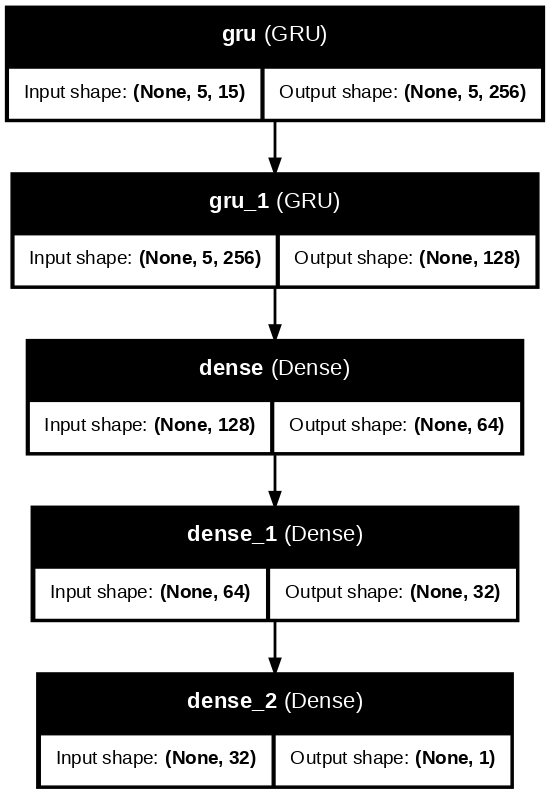

In [6]:
# Visualize the model architecture
from tensorflow.keras.utils import plot_model
plot_model(generator,
           to_file='generator_keras_model.png',  # Output file
           show_shapes=True,                         # Show input/output shapes
           show_layer_names=True,                    # Show layer names
           dpi=100)

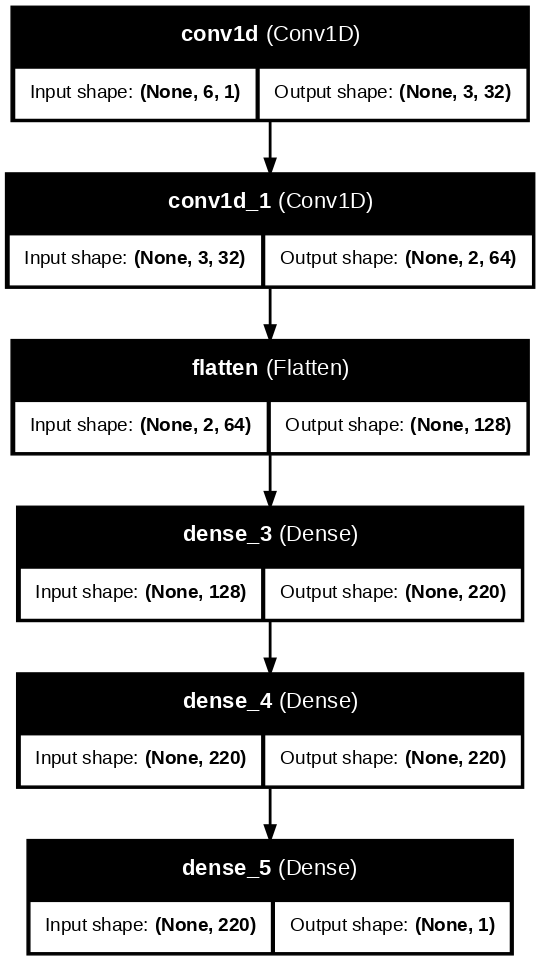

In [7]:
# Visualize the model architecture
from tensorflow.keras.utils import plot_model
plot_model(discriminator,
           to_file='discriminator_keras_model.png',  # Output file
           show_shapes=True,                         # Show input/output shapes
           show_layer_names=True,                    # Show layer names
           dpi=100)

In [8]:
epochs = 1500
d_losses, g_losses = gan.train(X_train, y_train, yc_train, epochs)

Epoch 10/1500, D Loss: 8.42078971862793, G Loss: -0.12006789445877075
Epoch 20/1500, D Loss: 8.116920471191406, G Loss: -0.4653623402118683
Epoch 30/1500, D Loss: 7.915102958679199, G Loss: -0.9165438413619995
Epoch 40/1500, D Loss: 7.206118583679199, G Loss: -0.4891471266746521
Epoch 50/1500, D Loss: 5.546741008758545, G Loss: 0.7089093327522278
Epoch 60/1500, D Loss: 4.225677490234375, G Loss: 1.1504876613616943
Epoch 70/1500, D Loss: 3.2994842529296875, G Loss: 0.6444668173789978
Epoch 80/1500, D Loss: 2.0600571632385254, G Loss: -0.433376669883728
Epoch 90/1500, D Loss: 0.7816824913024902, G Loss: -0.5938803553581238
Epoch 100/1500, D Loss: 0.3373309373855591, G Loss: -0.6911364793777466
Epoch 110/1500, D Loss: 0.2849500775337219, G Loss: -0.7207803130149841
Epoch 120/1500, D Loss: 0.227073073387146, G Loss: -0.7056865692138672
Epoch 130/1500, D Loss: 0.20605289936065674, G Loss: -0.6918098330497742
Epoch 140/1500, D Loss: 0.15812590718269348, G Loss: -0.6952244639396667
Epoch 150/

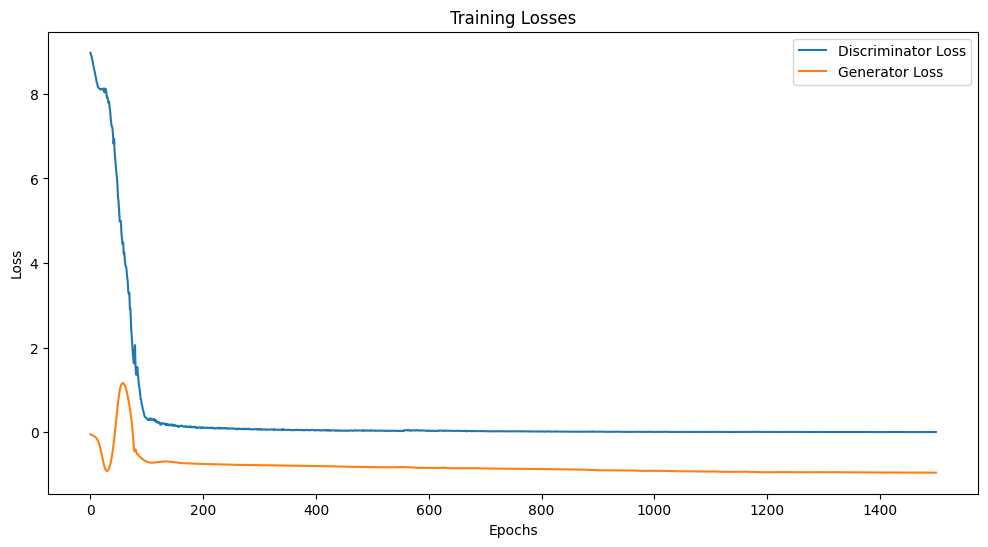

In [9]:
# Plot losses
plt.figure(figsize=(12, 6))
plt.plot(d_losses, label="Discriminator Loss")
plt.plot(g_losses, label="Generator Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Losses")
plt.show()

In [10]:
# Save the generator model in the `.keras` format
generator.save("wgan_generator.keras")
print("Generator model saved successfully!")



Generator model saved successfully!


In [11]:
# Load the generator model
loaded_generator = tf.keras.models.load_model("wgan_generator.keras")
print("Generator model loaded successfully!")

# Generate Predictions using the loaded generator
Predicted_train = loaded_generator(X_train, training=False).numpy()
Predicted_test = loaded_generator(X_test, training=False).numpy()

# Rescale back to original
y_scaler = load(open("y_scaler.pkl", "rb"))
rescaled_train = y_scaler.inverse_transform(Predicted_train)
rescaled_test = y_scaler.inverse_transform(Predicted_test)

# Evaluate model
train_metrics = evaluate_model(y_train, Predicted_train, y_scaler)
test_metrics = evaluate_model(y_test, Predicted_test, y_scaler)




Generator model loaded successfully!
MSE: 32.9296, RMSE: 5.7384, MAPE: 0.0319
MSE: 22.2314, RMSE: 4.7150, MAPE: 0.0298


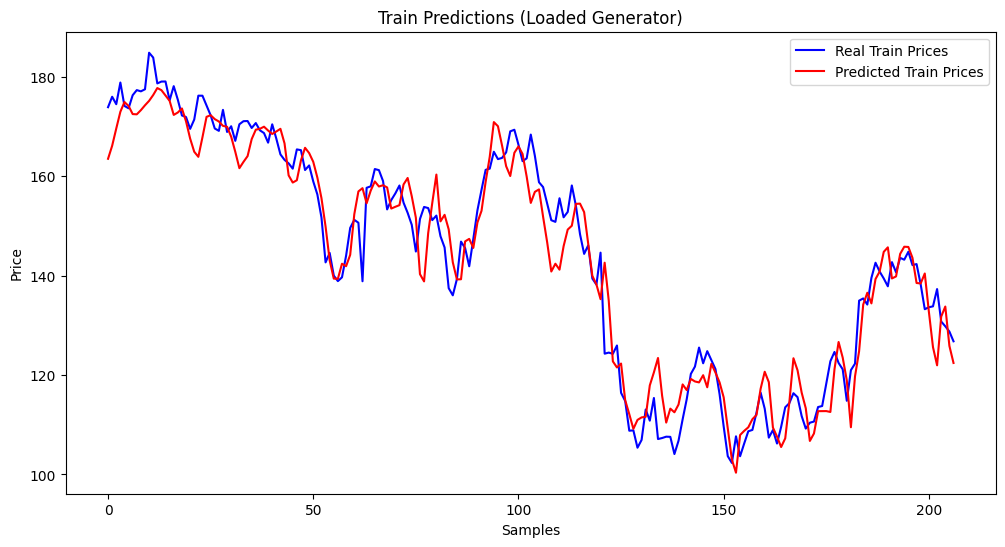

In [12]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(y_scaler.inverse_transform(y_train), label="Real Train Prices", color="blue")
plt.plot(rescaled_train, label="Predicted Train Prices", color="red")
plt.xlabel("Samples")
plt.ylabel("Price")
plt.legend()
plt.title("Train Predictions (Loaded Generator)")
plt.show()



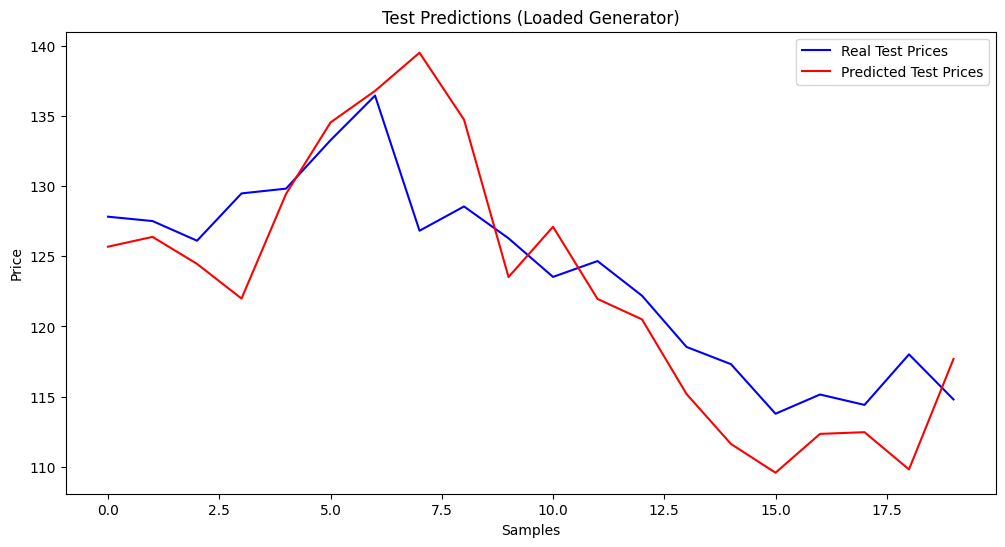

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(y_scaler.inverse_transform(y_test), label="Real Test Prices", color="blue")
plt.plot(rescaled_test, label="Predicted Test Prices", color="red")
plt.xlabel("Samples")
plt.ylabel("Price")
plt.legend()
plt.title("Test Predictions (Loaded Generator)")
plt.show()